In [2]:
%load_ext pyinstrument
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import tqdm
import copy

local


In [3]:
#%%pyinstrument
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)

(1099, 1)

{'main': CompoundNamed(comment='.signal.main')}


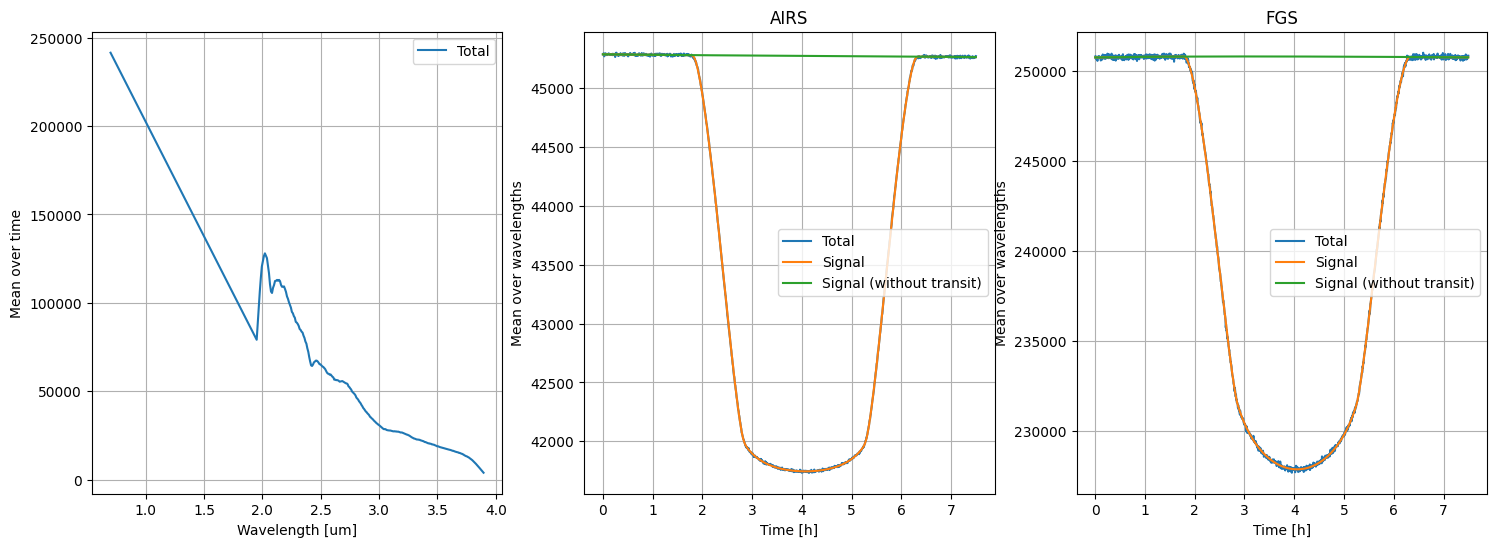

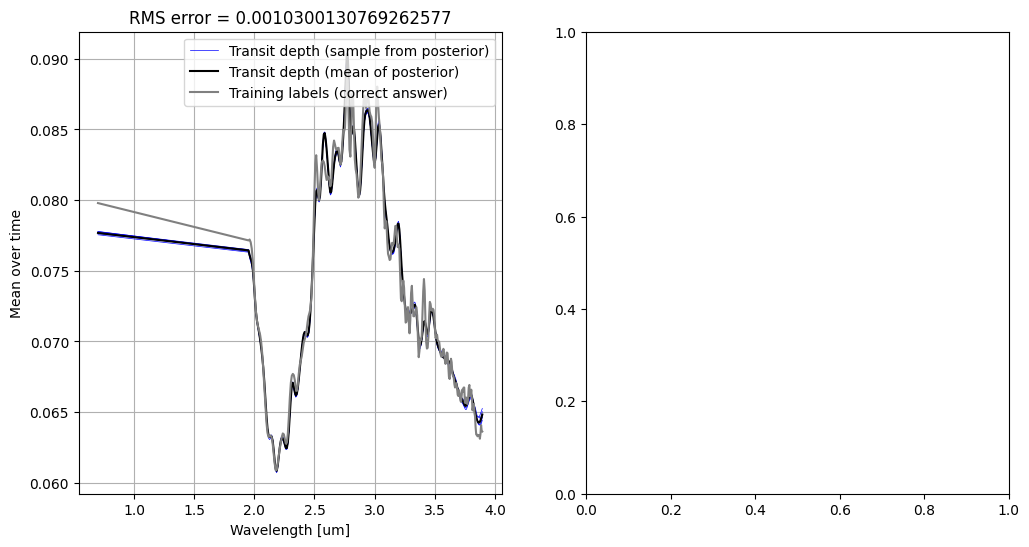

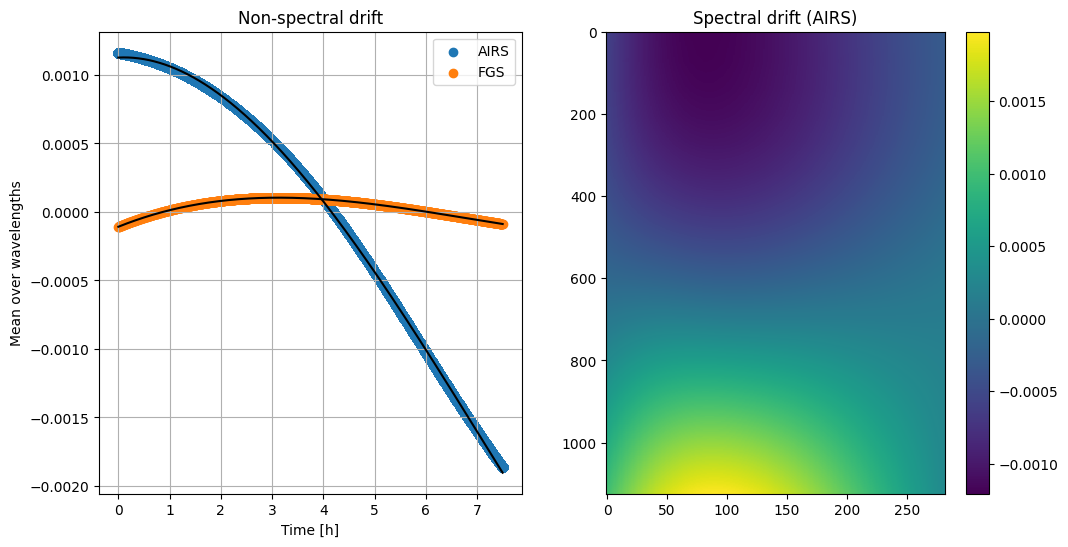

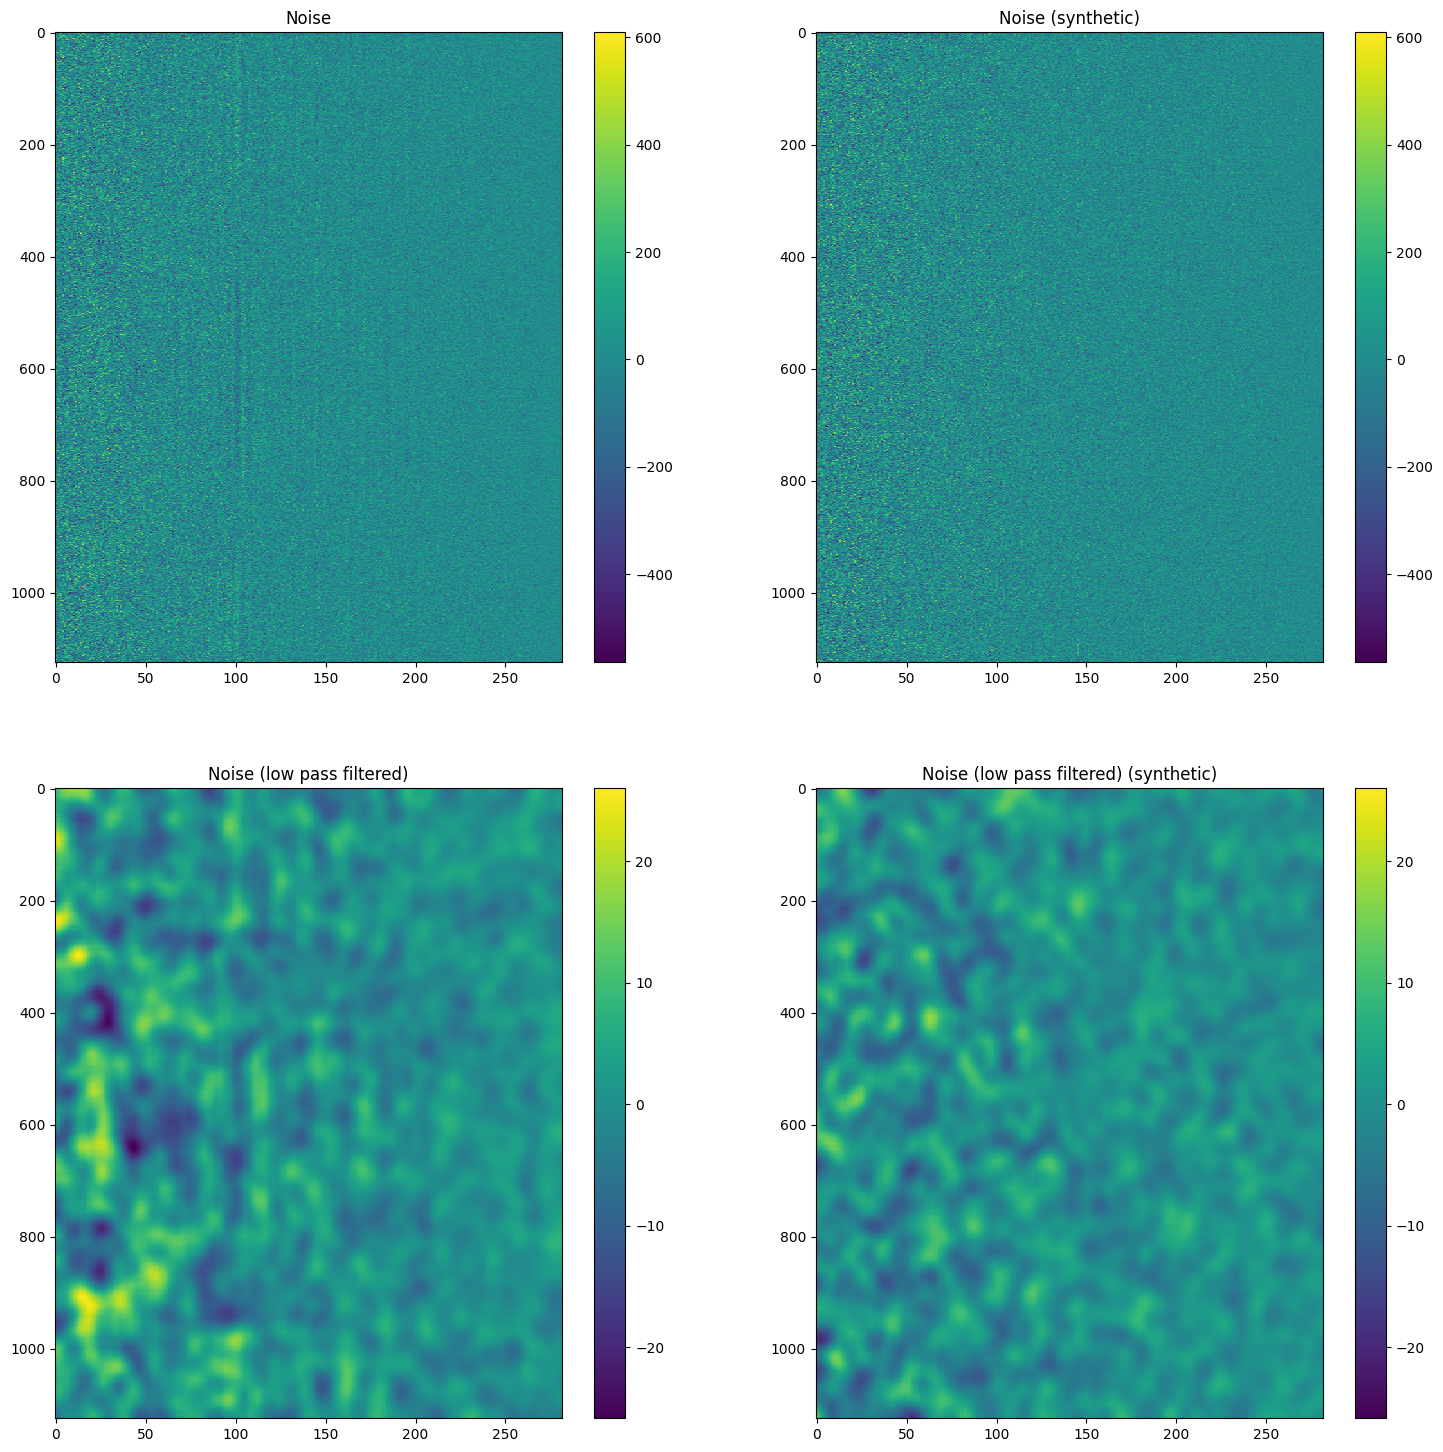

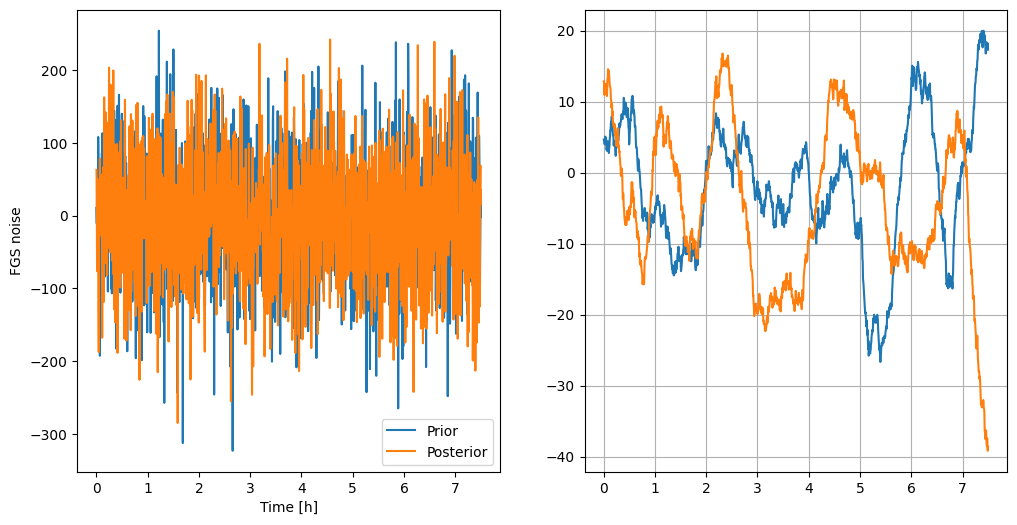

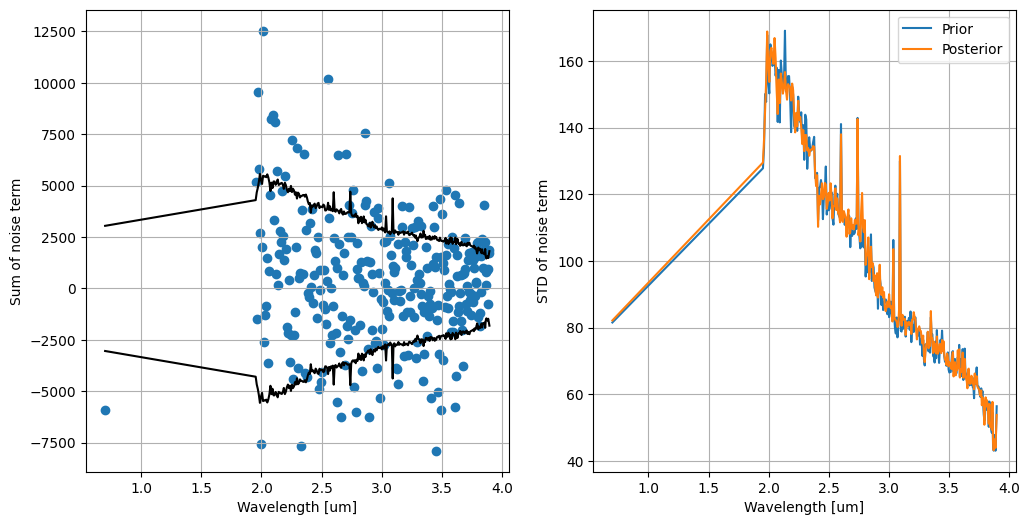

Score:           -10.5560
RMS error FGS:   2111.59 ppm
mRMS error FGS:  2111.59 ppm
RMS error AIRS:  1024.15 ppm
mRMS error AIRS: 1024.15 ppm
Score:           -12.8174
RMS error FGS:   2124.20 ppm
mRMS error FGS:  2124.20 ppm
RMS error AIRS:  7642.87 ppm
mRMS error AIRS: 7642.87 ppm
CPU times: user 24.5 s, sys: 5.17 s, total: 29.7 s
Wall time: 31.3 s


(-12.817434149544669, 0.0021242025805679743, 0.007642870673020171)

In [4]:
%%time
import gp
import ariel_gp
import ariel_load_FGS
importlib.reload(ariel_load_FGS)
importlib.reload(ariel_load)
kgs.profiling=False
kgs.debugging_mode=1
kgs.sanity_checks_active=False
importlib.reload(gp)
importlib.reload(ariel_gp)
model = ariel_gp.PredictionModel()  
model.run_in_parallel=False
model.model_options.use_training_labels = False
model.starter_model.do_plots = False
model.plot_final = True
model.plot_simple = False
model.model_options.include_background = False
model.model_options.n_iter = 4
model.train(train_data)
#model.starter_model.loaders[0].cache_steps = [5]

for ii in range(2):                
    pass
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True                 
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[3] = 10000
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[2] = 10000
    # model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[4] = True
    #model.loaders[ii].apply_pixel_corrections.mask_hot = False
    #model.loaders[ii].apply_pixel_corrections.mask_hot = False
#model.loaders[1].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[1] = 1
#model.loaders[0].cache_steps = []
model.starter_model.loaders = model.loaders


loaders = model.starter_model.loaders
#loaders[0].cache_steps= []
loaders[0].apply_wavelength_binning = ariel_load_FGS.ApplyWavelengthBinningFGS2()
loaders[0].apply_wavelength_binning.n_mean_pixels = 0
loaders[0].apply_pixel_corrections.mask_hot = False
loaders[0].apply_full_sensor_corrections.inpainting_2d = True
loaders[0].apply_full_sensor_corrections.restore_invalids = True
loaders[0].apply_full_sensor_corrections.remove_background_based_on_pixels = True
# old_weights = copy.deepcopy(ariel_load_FGS.FGS_weights)
# ariel_load_FGS.FGS_weights *= 0
# ariel_load_FGS.FGS_weights[0,0] = old_weights[0,0]
#print(ariel_load_FGS.FGS_weights)
#ariel_load_FGS.FGS_weights[3] = 1
model.model_options.FGS_order = 3
#model.model_options.AIRS_order = 3
#loaders[0].apply_wavelength_binning.options.use_sum = True
# loaders[1].apply_full_sensor_corrections.inpainting_wavelength = False
# loaders[1].apply_pixel_corrections.mask_hot = False
# loaders[1].apply_full_sensor_corrections.use_pca_for_background_removal = False
# loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = False
# loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = False
# loaders[1].apply_wavelength_binning = ariel_load.ApplyWavelengthBinningAIRS2()
# loaders[1].apply_wavelength_binning.make_diagnostic_plots = False
# loaders[1].apply_wavelength_binning.residual_threshold = np.inf
# loaders[1].apply_wavelength_binning.sequential_fit = True


            
#model.loaders[0].cache_steps = [5]
data = [train_data[[d.planet_id for d in train_data].index(1843015807)]] # ingress and egress obscured
1349926825
#data = train_data[1:2]
data = [train_data[[d.planet_id for d in train_data].index(1349926825)]]
#data = train_data[2:3]
#data = [train_data[[d.planet_id for d in train_data].index(2270815333)]] # ingress and egress obscured
data= copy.deepcopy(data)
for d in data:
    d.load_to_step(5,model.loaders)
    #d.transits[0].data[1].noise_est*=1000
#print('!!!')
#d.transits = d.transits[1:]
inferred_data = model.infer(data)
kgs.score_metric(inferred_data, data)
model.starter_model.do_plots = False
inferred_data_simple = model.starter_model.infer(data)
kgs.score_metric(inferred_data_simple, data)

{'main': CompoundNamed(comment='.signal.main')}


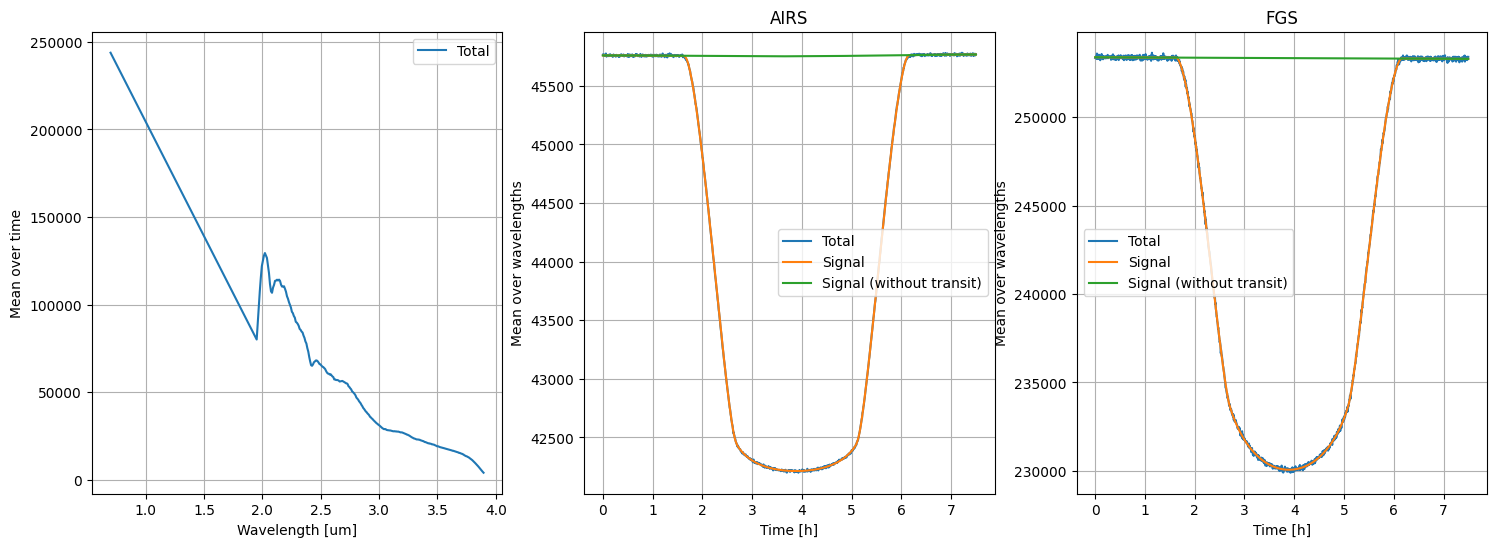

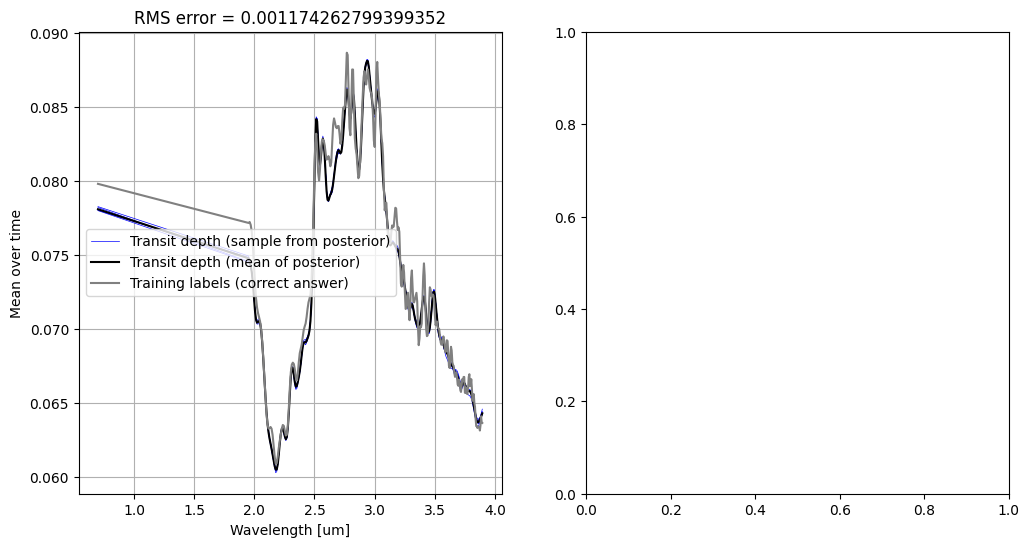

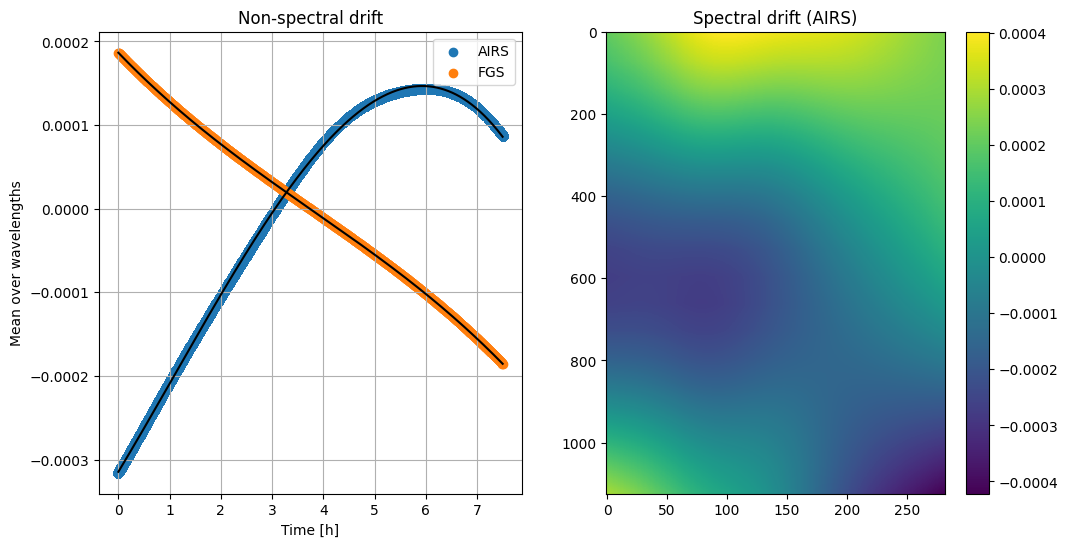

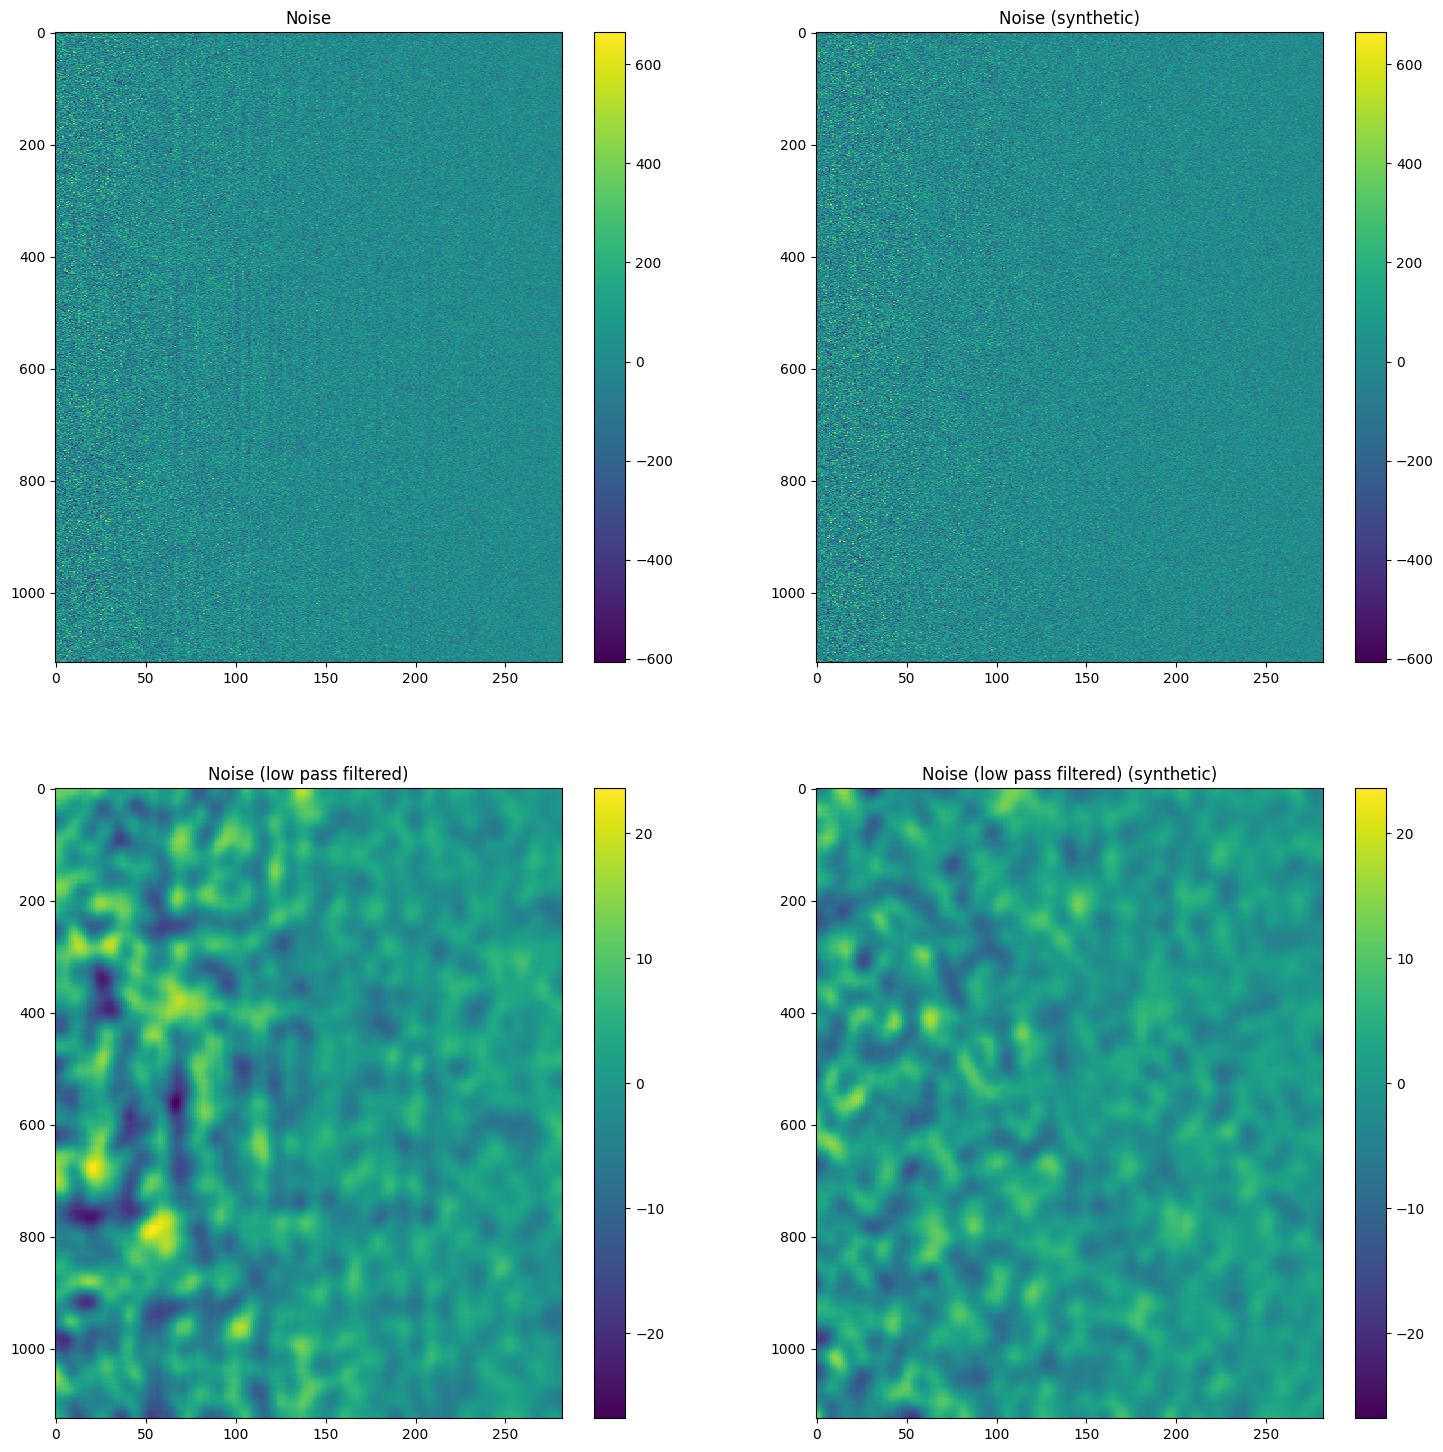

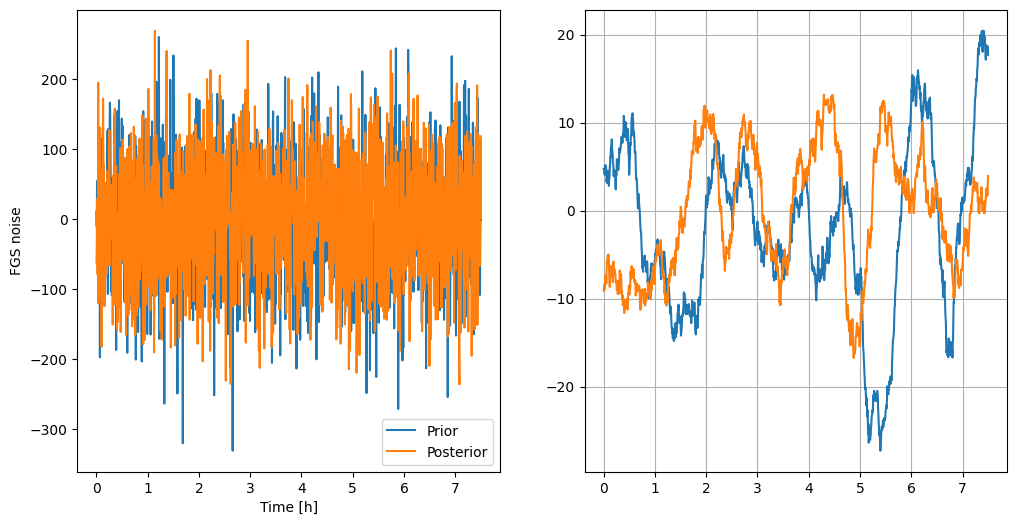

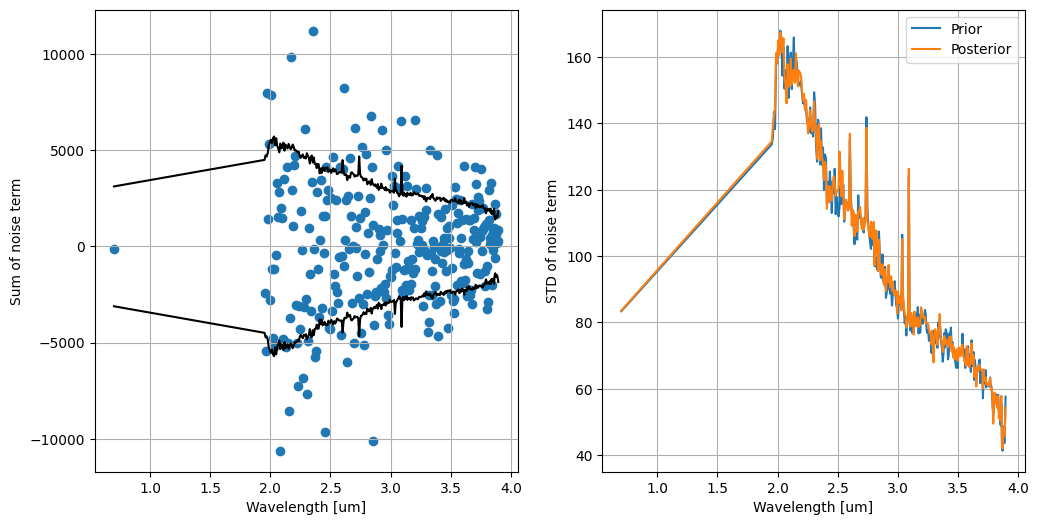

In [33]:
data2 = copy.deepcopy(data)
data2[0].transits = data2[0].transits[1:]
inferred_data2 = model.infer(data2)

<Figure size 640x480 with 0 Axes>

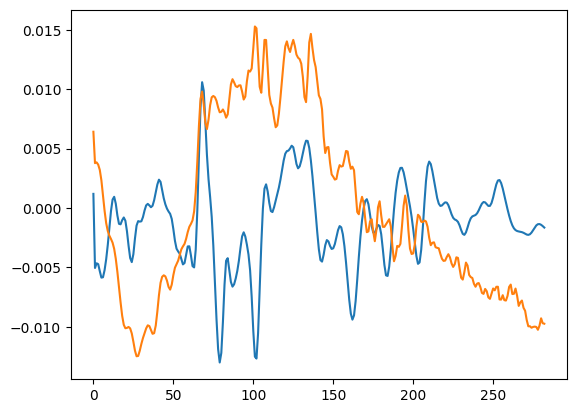

<Figure size 640x480 with 0 Axes>

In [45]:
plt.figure()
plt.plot(3*(inferred_data2[0].spectrum - inferred_data[0].spectrum))
plt.plot(data[0].spectrum-np.mean(data[0].spectrum))
plt.figure()


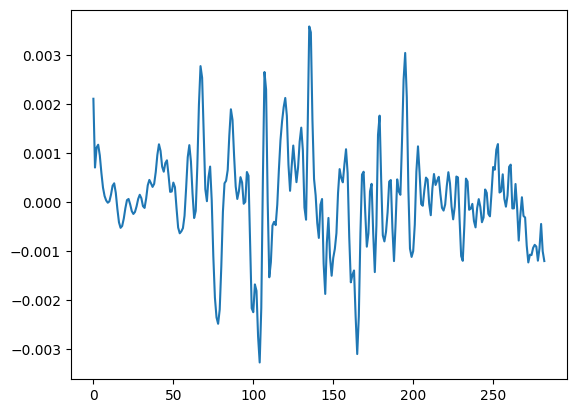

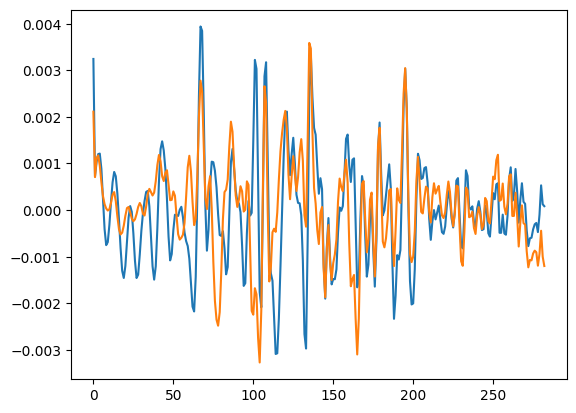

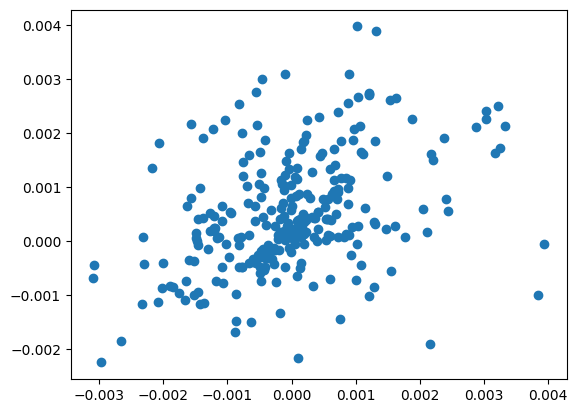

In [41]:
plt.figure()
plt.plot(data[0].spectrum - inferred_data[0].spectrum)
plt.figure()
xx = data[0].spectrum
plt.plot(xx-kgs.gaussian_2D_filter_with_nans(xx[:,None],[5,0.001])[:,0])
# plt.plot(np.diff(data[0].spectrum))
plt.plot((data[0].spectrum - inferred_data[0].spectrum))
plt.figure()
plt.scatter(xx-kgs.gaussian_2D_filter_with_nans(xx[:,None],[5,0.001])[:,0], data[0].spectrum - inferred_data2[0].spectrum)
# plt.figure()
# plt.scatter(np.diff(data[0].spectrum), (data[0].spectrum - inferred_data[0].spectrum)[:-1])
# plt.figure()
# plt.scatter(np.diff(data[0].spectrum,n=2), (data[0].spectrum - inferred_data[0].spectrum)[:-2])

In [24]:
(data[0].spectrum-np.mean(data[0].spectrum)[:,None]

SyntaxError: incomplete input (4263582772.py, line 1)

0.6836474562081964
-5.2093011227359645
-5.573499379412353


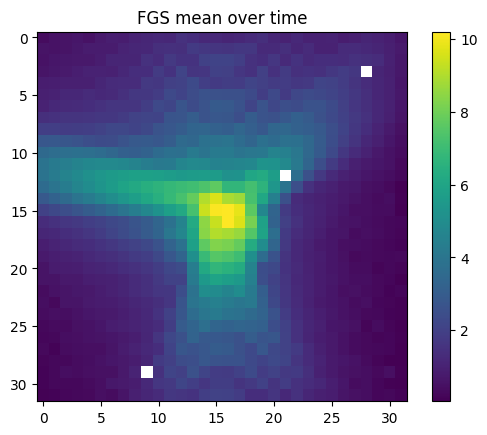

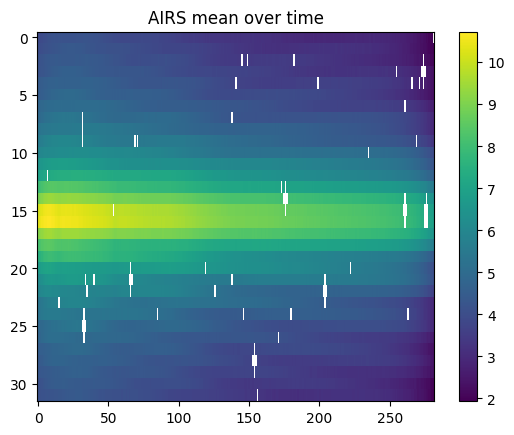

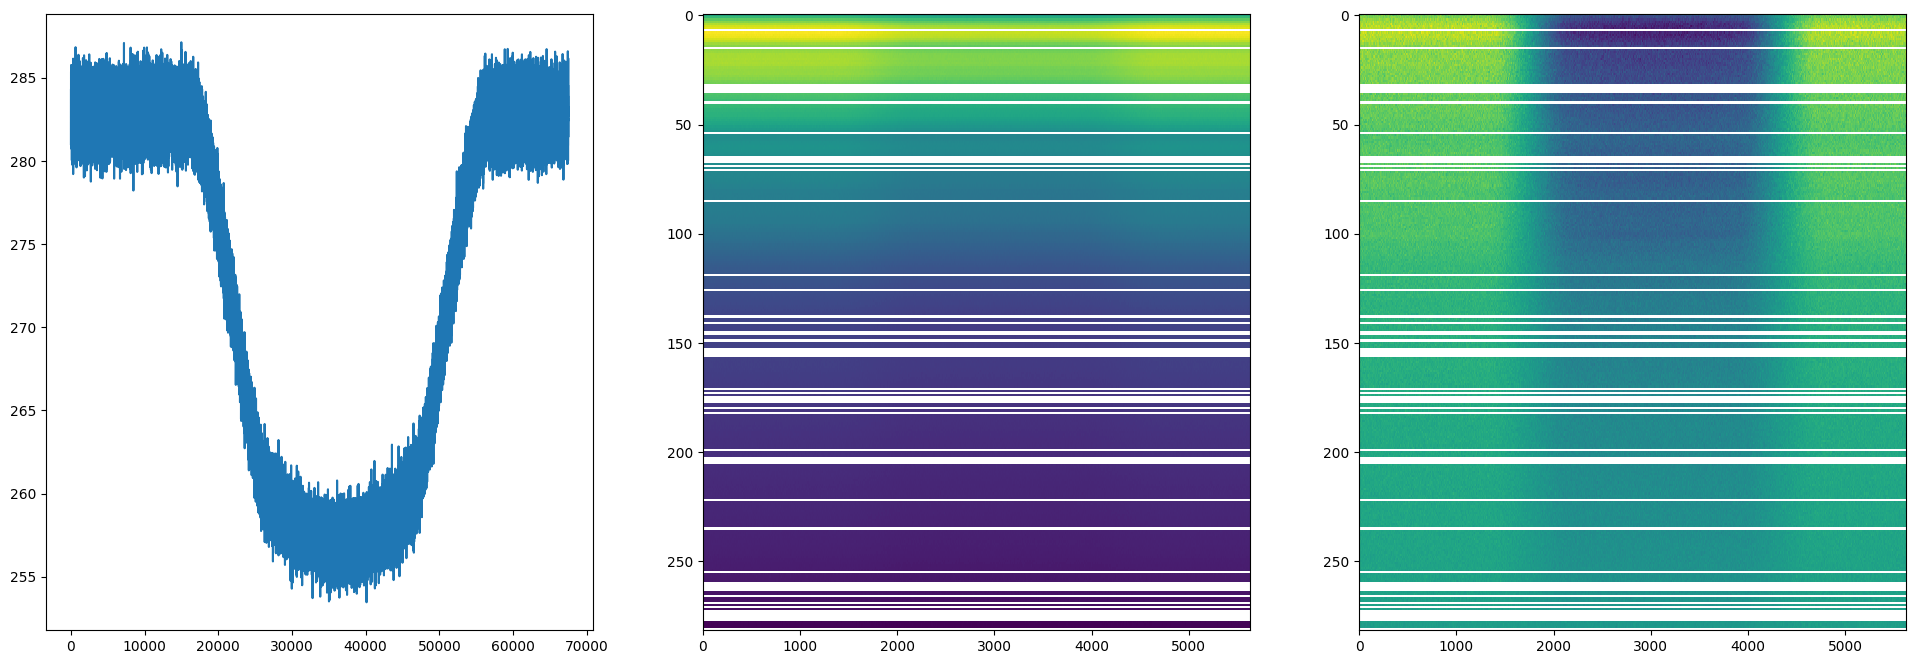

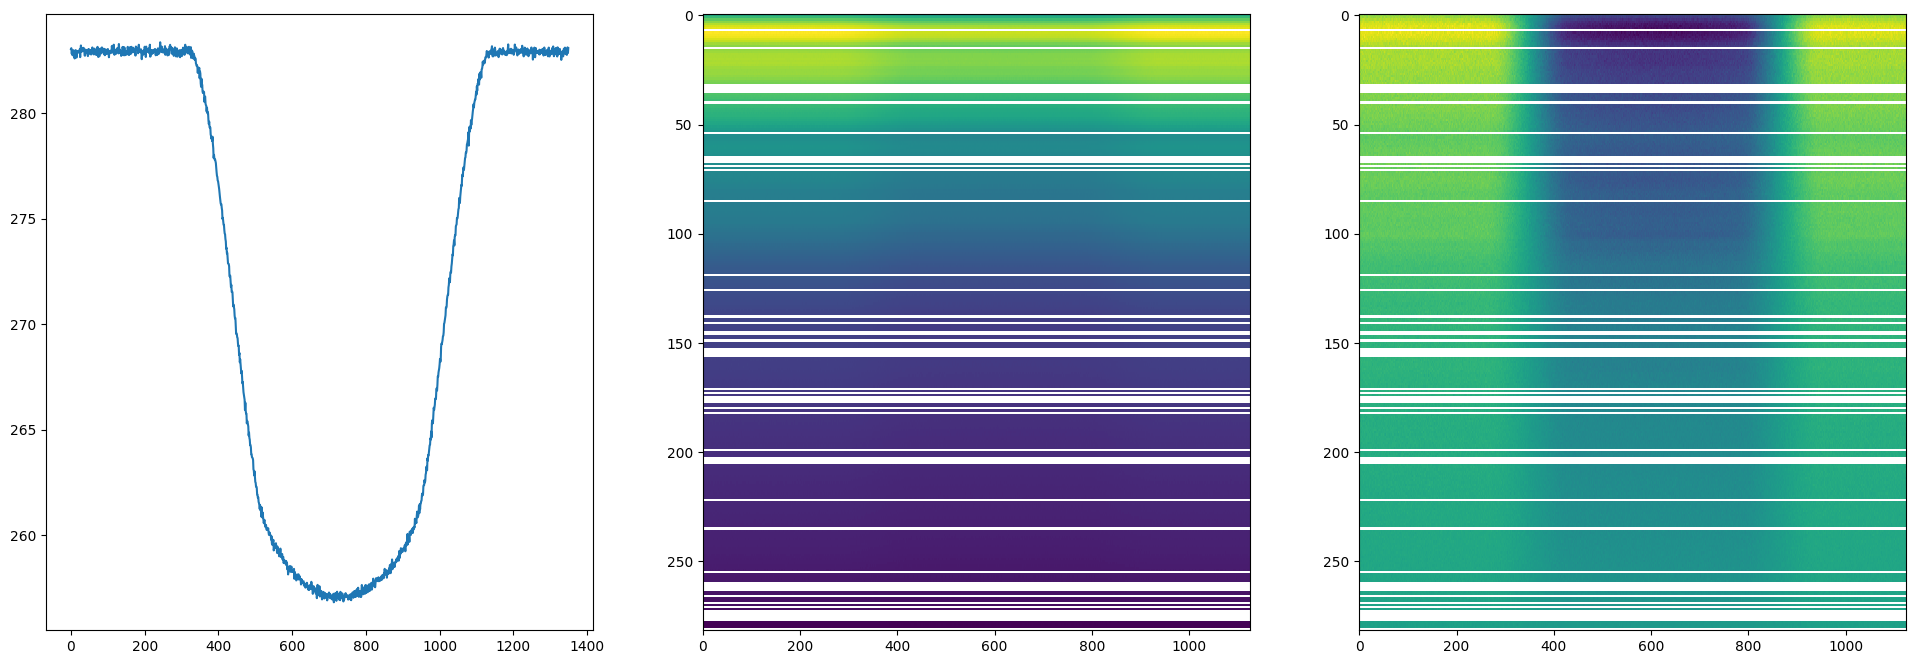

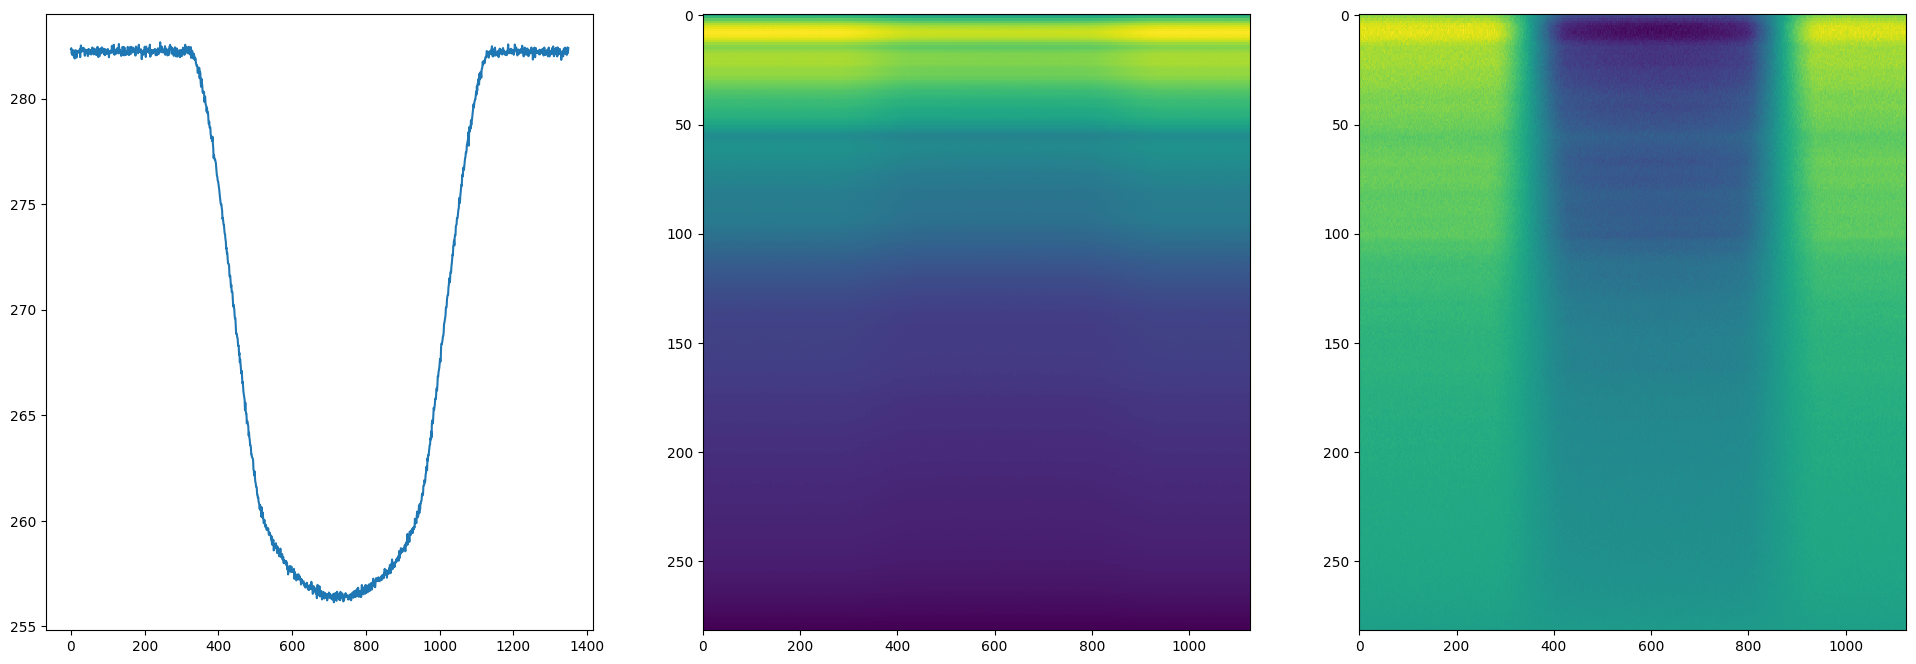

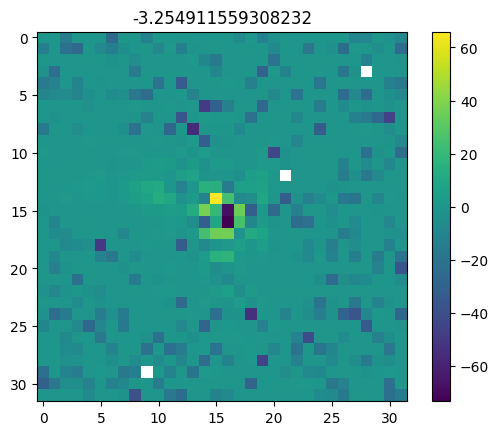

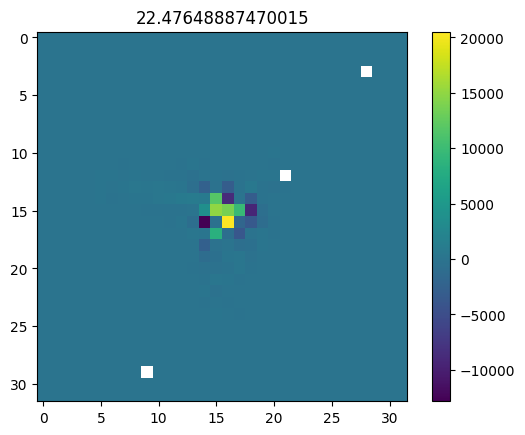

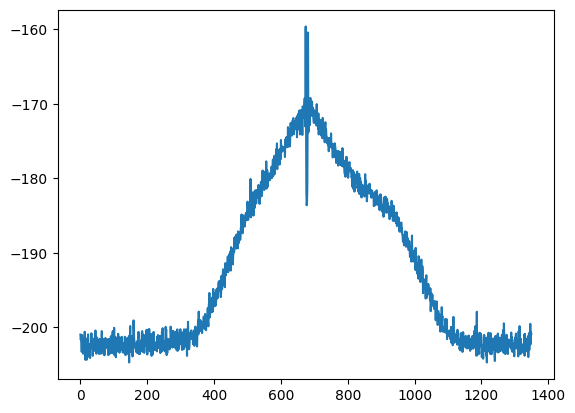

In [5]:
import ariel_load
importlib.reload(ariel_load)
importlib.reload(ariel_load_FGS)
loaders = ariel_load.default_loaders()
loaders[0].cache_steps = []
loaders[0].apply_wavelength_binning = ariel_load_FGS.ApplyWavelengthBinningFGS2()
loaders[0].apply_wavelength_binning.n_mean_pixels = 0
loaders[0].apply_pixel_corrections.mask_hot = False
loaders[0].apply_full_sensor_corrections.inpainting_2d = True
loaders[0].apply_full_sensor_corrections.restore_invalids = True
loaders[0].apply_full_sensor_corrections.remove_background_based_on_pixels = True
ariel_load.raw_data_diagnostics(data[0], 0, loaders)

In [6]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.
